## Try Polars
This notebook is just for learning polars

# import libraries

In [1]:
import os
import gc
import pickle
import glob
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import cv2
import matplotlib.pyplot as plt
import time
import math
import sys

import polars as pl

import lightgbm as lgb
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from catboost import CatBoostClassifier, Pool

import xgboost as xgb
import torch
import cupy 
import cudf
from cuml import ForestInference

from sklearn.metrics import matthews_corrcoef, confusion_matrix, roc_auc_score
from sklearn.model_selection import GroupKFold
from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore")

# Set Configurations

In [2]:
CFG = {
    "DEBUG" : False,
    "EXP_NAME" : "expCAT002",
    "n_folds" : 5,
    "train_folds" : [0,1,2,3,4],
    
}

CFG["cat_params"] = {
            'iterations': 10000,
            'learning_rate' : 0.01,
            'loss_function' : 'Logloss',
            'eval_metric' : 'AUC',
            'verbose' : 200,
            'random_seed' : 42,
            'use_best_model': True,
}


CFG["lgb_params"] = { 'boosting_type' :'dart',
                      'objective': 'binary',
                      'random_state': 21,
                      'learning_rate': 0.01,
                      'n_estimators':5000,
                      }

# CFG["xgb_params"] =  {
#                         'objective': 'binary:logistic',
#                         'eval_metric': 'auc',
#                         'learning_rate':0.01,
#                         'tree_method':'hist' if not torch.cuda.is_available() else 'gpu_hist',
#                         'seed': 42,
#                     }

if CFG["DEBUG"]:
    CFG["EXP_CATEGORY"] = "DEBUG"
    CFG["sample_num"] = 1000

CFG["INPUT_DIR"] = "/workspace/input"
CFG["OUTPUT_DIR"] = "/workspace/output"
CFG["BASE_DIR"] = os.path.join(CFG["INPUT_DIR"])
CFG["TRAIN_HELMET_CSV"] = os.path.join(CFG["BASE_DIR"], "train_baseline_helmets.csv")
CFG["TRAIN_TRACKING_CSV"] = os.path.join(CFG["BASE_DIR"], "train_player_tracking.csv")
CFG["TRAIN_VIDEO_META_CSV"] = os.path.join(CFG["BASE_DIR"], "train_video_metadata.csv")
CFG["TRAIN_LABEL_CSV"] = os.path.join(CFG["BASE_DIR"], "train_labels.csv")

CFG["NN_FEATURE_CSV_1"] = os.path.join(CFG["OUTPUT_DIR"], "expP011_PandG_bothview_swins3base224", "oof_df.csv")
CFG["NN_FEATURE_CSV_2"] = os.path.join(CFG["OUTPUT_DIR"], "expP014_PandG_nomask_swins3base224", "oof_df.csv")
CFG["NN_FEATURE_CSV_3"] = os.path.join(CFG["OUTPUT_DIR"], "expP015_PandG_nomaskzoom_swins3base224", "oof_df.csv")

CFG["TRACK_FEATURE_CSV"] = os.path.join(CFG["OUTPUT_DIR"], "expT010_Trackshift1D", "oof_df.csv")

CFG["TEST_HELMET_CSV"] = os.path.join(CFG["BASE_DIR"], "test_baseline_helmets.csv")
CFG["TEST_TRACKING_CSV"] = os.path.join(CFG["BASE_DIR"], "test_player_tracking.csv")
CFG["TEST_VIDEO_META_CSV"] = os.path.join(CFG["BASE_DIR"], "test_video_metadata.csv")
CFG["TEST_LABEL_CSV"] = os.path.join(CFG["BASE_DIR"], "sample_submission.csv")


CFG["EXP_DIR"] = os.path.join(CFG["OUTPUT_DIR"], CFG["EXP_NAME"])
if not CFG["DEBUG"]:
    os.mkdir(CFG["EXP_DIR"])

# MODEL Functions

In [3]:
def fit_lgboost(df_, feature_cols_):
    kf = GroupKFold(n_splits=CFG["n_folds"])
    X = df_[feature_cols_]
    y = df_["contact"]
    oof_pred = np.zeros(len(y), dtype=np.float32)
    generator = kf.split(X, y, df_["game_id"])
    for fold, (idx_train, idx_valid) in enumerate(generator):
        print("-")
        print(f"fold {fold}")
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
        display(pd.Series(y_valid).value_counts())

        params = CFG["lgb_params"]
        model = LGBMClassifier(**params).fit(x_train, y_train, 
                                   eval_set=[(x_train, y_train), (x_valid, y_valid)],
                                   callbacks=[early_stopping(200), log_evaluation(100)],
                                   eval_metric=['auc'],)

        model_path = os.path.join(CFG["EXP_DIR"], f'lgb_fold{fold}.model')
        pickle.dump(model, open(model_path, 'wb'))
        importance = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])
        display(importance.sort_values("importance", ascending=False).head(20))

        pred_i = model.predict_proba(x_valid)[:, 1]
        oof_pred[x_valid.index] = pred_i
        score = round(roc_auc_score(y_valid, pred_i), 5)
        print(f'Performance of the prediction: {score}\n')
        del model; gc.collect()

    oof_pred_file = os.path.join(CFG["EXP_DIR"], 'oof_pred')
    df_["pred"] = oof_pred
    np.save(oof_pred_file, oof_pred)
    auc = round(roc_auc_score(y, oof_pred), 5)
    
    def func(x_list):
        score = matthews_corrcoef(df_['contact'], df_["pred"]>x_list[0])
        return -score
    x0 = [0.5]
    result = minimize(func, x0,  method="nelder-mead")
    opt_threshold = result.x[0]
    score = round(matthews_corrcoef(df_['contact'], df_["pred"]>opt_threshold), 5)
    
    print(f'All Performance of the AUC:{auc}, MCC:{score}')
    return oof_pred


In [4]:
def fit_catboost(df_, feature_cols_):
    kf = GroupKFold(n_splits=CFG["n_folds"])
    X = df_[feature_cols_]
    y = df_["contact"]
    oof_pred = np.zeros(len(y), dtype=np.float32)
    generator = kf.split(X, y, df_["game_id"])
    for fold, (idx_train, idx_valid) in enumerate(generator):
        print("-")
        print(f"fold {fold}")
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
        display(pd.Series(y_valid).value_counts())

        params = CFG["cat_params"]
        model =  CatBoostClassifier(**params)
        model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], verbose=100, early_stopping_rounds=200)
        model_path = os.path.join(CFG["EXP_DIR"], f'cat_fold{fold}.model')
        pickle.dump(model, open(model_path, 'wb'))
        importance = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])
        display(importance.sort_values("importance", ascending=False).head(20))

        pred_i = model.predict_proba(x_valid)[:, 1]
        oof_pred[x_valid.index] = pred_i
        score = round(roc_auc_score(y_valid, pred_i), 5)
        print(f'Performance of the prediction: {score}\n')
        del model; gc.collect()
    
    oof_pred_file = os.path.join(CFG["EXP_DIR"], 'oof_pred')
    df_["pred"] = oof_pred
    np.save(oof_pred_file, oof_pred)
    auc = round(roc_auc_score(y, oof_pred), 5)
    
    def func(x_list):
        score = matthews_corrcoef(df_['contact'], df_["pred"]>x_list[0])
        return -score
    x0 = [0.5]
    result = minimize(func, x0,  method="nelder-mead")
    opt_threshold = result.x[0]
    score = round(matthews_corrcoef(df_['contact'], df_["pred"]>opt_threshold), 5)
    
    print(f'All Performance of the AUC:{auc}, MCC:{score}')
    return oof_pred

In [5]:
def fit_xgboost(df_, feature_cols_):
    kf = GroupKFold(n_splits=CFG["n_folds"])
    X = df_[feature_cols_]
    y = df_["contact"]
    oof_pred = np.zeros(len(y), dtype=np.float32)
    generator = kf.split(X, y, df_["game_play"])
    for fold, (idx_train, idx_valid) in enumerate(generator):
        print("-")
        print(f"fold {fold}")
        # set dataset
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
        display(pd.Series(y_valid).value_counts())
        xgb_train = xgb.DMatrix(x_train, label=y_train)
        xgb_valid = xgb.DMatrix(x_valid, label=y_valid)
        evals = [(xgb_train,'train'),(xgb_valid,'eval')]
        # fit
        params = CFG["xgb_params"]
        model = xgb.train(
            params,
            xgb_train,
            num_boost_round=10_000,
            early_stopping_rounds=200,
            evals=evals,
            verbose_eval=100,
        )

        model_path = os.path.join(CFG["EXP_DIR"], f'xgb_fold{fold}.model')
        model.save_model(model_path)
        _, ax = plt.subplots(figsize=(20, 16))
        xgb.plot_importance(model,
                            ax=ax,
                            importance_type='gain',
                            show_values=False)
        plt.show()

        if not torch.cuda.is_available():
            model = xgb.Booster().load_model(model_path)
        else:
            model = ForestInference.load(model_path, output_class=True, model_type='xgboost')
        
        pred_i = model.predict_proba(x_valid)[:, 1]
        oof_pred[x_valid.index] = pred_i
        score = round(roc_auc_score(y_valid, pred_i), 5)
        print(f'Performance of the prediction: {score}\n')
        del model; gc.collect()
    
    oof_pred_file = os.path.join(CFG["EXP_DIR"], 'oof_pred')
    df_["pred"] = oof_pred
    np.save(oof_pred_file, oof_pred)
    auc = round(roc_auc_score(y, oof_pred), 5)
    
    def func(x_list):
        score = matthews_corrcoef(df_['contact'], df_["pred"]>x_list[0])
        return -score
    x0 = [0.5]
    result = minimize(func, x0,  method="nelder-mead")
    opt_threshold = result.x[0]
    score = round(matthews_corrcoef(df_['contact'], df_["pred"]>opt_threshold), 5)
    
    print(f'All Performance of the AUC:{auc}, MCC:{score}')
    return oof_pred

# Dataset Functions

In [6]:
def add_feature_cols(df_, feature_cols_, remove_col_list):
    additional_cols = list(df_.columns)
    additional_cols = [col for col in additional_cols if not col in remove_col_list]
    feature_cols_.extend(additional_cols)
    return feature_cols_

## Merge Functions

In [7]:
def target_merge_tracking(target_df_, tracking_df_, feature_cols_, SHIFT_COLS_):
    target_df_ = target_df_.with_column(pl.concat_str([pl.col("game_play"),
                                                     pl.col("step").cast(str),
                                                     pl.col("nfl_player_id_1"),
                                                    ], sep='_').alias('game_step_player_1'))
    target_df_ = target_df_.with_column(pl.concat_str([pl.col("game_play"),
                                                     pl.col("step").cast(str),
                                                     pl.col("nfl_player_id_2"),
                                                    ], sep='_').alias('game_step_player_2'))
    # line man positions
    lineman_pos = ["T", "G", "C", "DE", "DT", "NG"]
    tracking_df_ = tracking_df_.with_column((pl.col("position").is_in(lineman_pos)).cast(int).alias('is_lineman'))
    
    
    # Norm cols
    norm_cols = ["x_position", "y_position", "direction", "orientation"]
    Norm_value_list = [120., 60., 360., 360.]
    for col, norm_val in zip(norm_cols, Norm_value_list):
        tracking_df_ = tracking_df_.with_column((pl.col(col)/norm_val).alias(col))
    
    # use columns
    track_cols = ["game_play", "nfl_player_id", "step", 
                   "x_position", "y_position", "datetime",
                   "speed","distance","direction","orientation",
                   "acceleration","sa", "team", "jersey_number",
                   "is_lineman",
                 ]
    track_cols.extend(SHIFT_COLS_)
    tracking_df_ = tracking_df_.select(track_cols)
    tracking_df_ = tracking_df_.with_column(pl.concat_str([pl.col("game_play"),
                                                         pl.col("step").cast(str),
                                                         pl.col("nfl_player_id"),
                                                        ], sep='_').alias('game_step_player'))

    tracking_df_ = tracking_df_.drop(["game_play", "step", "nfl_player_id", "datetime"])

    # merge tracking to target
    for player_id in [1,2]:
        tracking_player = tracking_df_.select([pl.all().suffix(f"_{player_id}")])
        target_df_ = target_df_.join(tracking_player, on=[f"game_step_player_{player_id}"], how="left")
        # add features col
        feature_cols_ = add_feature_cols(tracking_player, feature_cols_,
                                        [f"game_step_player_{player_id}", f"frame_{player_id}", f"datetime_{player_id}"])
    # drop col
    target_df_ = target_df_.drop(["game_step_player_1", "game_step_player_2"])
    print(len(target_df_.columns))
    print("original length", len(target_df_))
    return target_df_, feature_cols_

In [8]:
def target_merge_helmet(target_df_, helmet_df_, feature_cols_):
    print("original length", len(target_df_))
    # set merge-key (game_frame_player_1,2) to merge helmet_df
    target_df_ = target_df_.with_column(((pl.col("step").cast(int)/10*59.94+5*59.94).cast(int)+1).alias("frame"))
    target_df_ = target_df_.with_column(pl.concat_str([pl.col("game_play"),
                                                     pl.col("frame").cast(str),
                                                     pl.col("nfl_player_id_1"),
                                                    ], sep='_').alias('game_frame_player_1'))
    target_df_ = target_df_.with_column(pl.concat_str([pl.col("game_play"),
                                                     pl.col("frame").cast(str),
                                                     pl.col("nfl_player_id_2"),
                                                    ], sep='_').alias('game_frame_player_2'))
    # set merge key
    helmet_df_ = helmet_df_.with_column(pl.concat_str([pl.col("game_play"),
                                                     pl.col("frame").cast(str),
                                                     pl.col("nfl_player_id"),
                                                    ], sep='_').alias('game_frame_player'))

    # merge target df & helmet_df
    player_views = [[1, "Endzone"],[2, "Endzone"], [1, "Sideline"],[2, "Sideline"]]
    for player_id, view in player_views:
        helmet_view = helmet_df_.filter(pl.col("view")==view)
        helmet_view = helmet_view[["game_frame_player", "left", "width", "top", "height"]]
        helmet_view = helmet_view.select(pl.all().suffix(f"_{player_id}"))
        helmet_view = helmet_view.select([pl.col(helmet_view.columns[0]), pl.col(helmet_view.columns[1:]).prefix(f"{view[0]}_")])
        target_df_ = target_df_.join(helmet_view, on=f"game_frame_player_{player_id}", how="left")  
        # add features col
        feature_cols_ = add_feature_cols(helmet_view, feature_cols_, [f"game_frame_player_{player_id}"])

    print(len(target_df_.columns))
    print("original length", len(target_df_))
    return target_df_, feature_cols_

## Create feature function

In [9]:
def get_tracking_shift(tracking_df_, shift_cols=["x_position","y_position"], shift_nums=range(-6,6,1)):
    # get shift key
    tracking_df_ = tracking_df_.with_column(pl.concat_str([pl.col("game_play"),
                                                         pl.col("nfl_player_id"),
                                                        ], sep='_').alias('shift_key'))
    # get shift features
    shift_col_list = []
    for num in shift_nums:
        tracking_df_ = tracking_df_.with_columns(
                            pl.col(shift_cols).shift(periods=num).over("shift_key").suffix(f"_shift{num}"))
    for col in shift_cols:
        colname = [f"{col}_shift{idx}" for idx in shift_nums]
        shift_col_list.extend(colname)
                    
    return tracking_df_, shift_col_list

In [10]:
def create_trackmerged_ftr(target_df_, feature_cols_,
                           diff_cols = ['x_position', 'y_position', 'speed', 'distance',
                                        'direction', 'orientation', 'acceleration', 'sa']):    
#     target_df_ = target_df_.with_column((np.sqrt(np.square(pl.col("x_position_1")-pl.col("x_position_2")) \
#                                               + np.square(pl.col("y_position_1")-pl.col("y_position_2"))) \
#                                       ).alias("players_dis"))
    target_df_ = target_df_.with_column((np.sqrt(np.square(pl.col("x_position_1")*120. - pl.col("x_position_2")*120.) \
                                              + np.square(pl.col("y_position_1")*60. - pl.col("y_position_2")*60.)) \
                                      ).alias("players_dis"))
    target_df_ = target_df_.with_column(pl.col("players_dis").fill_null(0))
    
    # players distance sum(in shift range time : default(-6~6 frames not step))
    players_distance_sum = 0
    for idx in range(-6,6,1):
        players_distance_sum += np.sqrt((target_df_[f"x_position_shift{idx}_1"] - target_df_[f"x_position_shift{idx}_2"])**2 \
                                       + (target_df_[f"y_position_shift{idx}_1"] - target_df_[f"y_position_shift{idx}_2"])**2)
    target_df_ = target_df_.with_column(pl.Series("players_distance_sum", players_distance_sum))
    target_df_ = target_df_.with_column(pl.col("players_distance_sum").fill_null(0))
    feature_cols_.append("players_distance_sum")

    # players each axis distance sum(in shift range time : default(-6~6 frames not step))
    for axis in ["x", "y"]:
        axis_distance_1 = 0
        axis_distance_2 = 0
        for idx in range(-6, 5, 1):
            axis_distance_1 += abs(target_df_[f"{axis}_position_shift{idx}_1"] - target_df_[f"{axis}_position_shift{idx+1}_1"])
            axis_distance_2 += abs(target_df_[f"{axis}_position_shift{idx}_2"] - target_df_[f"{axis}_position_shift{idx+1}_2"])
        target_df_ = target_df_.with_column(pl.Series(f"{axis}_move_distance_1", axis_distance_1))
        target_df_ = target_df_.with_column(pl.col(f"{axis}_move_distance_1").fill_null(0))
        target_df_ = target_df_.with_column(pl.Series(f"{axis}_move_distance_2", axis_distance_2))
        target_df_ = target_df_.with_column(pl.col(f"{axis}_move_distance_2").fill_null(0))
        feature_cols_.extend([f"{axis}_move_distance_1", f"{axis}_move_distance_2"])

    # players difference ftr (in each step)
    for col in diff_cols:
        colname = f"{col}_diff"
        target_df_ = target_df_.with_column((abs(pl.col(f"{col}_1") - pl.col(f"{col}_2"))).alias(colname))
        target_df_ = target_df_.with_column(pl.col(colname).fill_null(0))
        feature_cols_.append(colname)
        
    return target_df_, feature_cols_

In [11]:
def create_roll_ftr(target_df_, feature_cols_,
                    roll_cols = ['players_dis', 'x_position_diff', 'y_position_diff', 
                                  'speed_diff', 'distance_diff','direction_diff',
                                  'orientation_diff', 'acceleration_diff', 'sa_diff'],
                    key_cols = ["contact_id", "game_play", "nfl_player_id_1", 
                                "nfl_player_id_2", "step"]):
    roll_df = target_df_.select(roll_cols+key_cols)

    roll_df = roll_df.with_column(pl.concat_str([pl.col("game_play"),
                                                 pl.col("nfl_player_id_1"),
                                                 pl.col("nfl_player_id_2"),
                                                ], sep='_').alias('key'))
    # cast datetime

    # groupby rolling
    roll_df = roll_df.groupby_dynamic("step", every="1i", period="6i", by="key", closed="both").agg([pl.col(roll_cols).sum().suffix("_rollsum"), pl.col("contact_id")])
    roll_df = roll_df.with_column(pl.col("contact_id").apply(lambda x:x[0]))
    roll_df = roll_df.drop(["key", "step"])
    target_df_ = target_df_.join(roll_df, on="contact_id", how="left")
    additional_cols = [col+"_rollsum" for col in roll_cols]
    feature_cols_.extend(additional_cols)
    return target_df_, feature_cols_

In [12]:
def create_helmetmerged_ftr(target_df_, feature_cols_):
    # helmet center distance feature
    for view in ["Endzone", "Sideline"]:
        for p_id in ["1", "2"]: 
            # get helmet center
            target_df_ = target_df_.with_column((pl.col(f"{view[0]}_left_{p_id}") + (pl.col(f"{view[0]}_width_{p_id}")//2)).alias(f"{view[0]}_Wcenter_{p_id}"))
            target_df_ = target_df_.with_column((pl.col(f"{view[0]}_top_{p_id}") + (pl.col(f"{view[0]}_height_{p_id}")//2)).alias(f"{view[0]}_Hcenter_{p_id}"))
        # helmet center distance
        target_df_ = target_df_.with_column((np.sqrt(np.square(pl.col(f"{view[0]}_Wcenter_1") - pl.col(f"{view[0]}_Wcenter_2")) \
                                                  + np.square(pl.col(f"{view[0]}_Hcenter_1") - pl.col(f"{view[0]}_Hcenter_2")))
                                          ).alias(f"{view[0]}_helmet_dis"))

        # GがNanになるので0にしておく
        target_df_ = target_df_.with_column(pl.col(f"{view[0]}_helmet_dis").fill_null(0))
        feature_cols_.append(f"{view[0]}_helmet_dis")
    
    # helmet cols fillna(0) after get helmet distance 
    helmet_cols = ['E_left_1', 'E_width_1', 'E_top_1', 'E_height_1',
                   'E_left_2', 'E_width_2', 'E_top_2', 'E_height_2', 
                   'S_left_1','S_width_1', 'S_top_1', 'S_height_1', 
                   'S_left_2', 'S_width_2', 'S_top_2', 'S_height_2']
    target_df_ = target_df_.with_column(pl.col(helmet_cols).fill_null(0))

    return target_df_, feature_cols_

In [13]:
def get_categorical_ftr(target_df_, feature_cols_):
    target_df_ = target_df_.with_column((pl.col("nfl_player_id_2")== "G").cast(int).alias("is_ground"))
    # set team 
    target_df_ = target_df_.with_column(((pl.col("team_1")=="home").cast(int)).alias("team_1"))
    target_df_ = target_df_.with_column(((pl.col("team_2")=="home").cast(int)).alias("team_2"))
    target_df_ = target_df_.with_column(pl.col('nfl_player_id_2').str.replace("G", "99999"))
    
    target_df_ = target_df_.with_column((1 - ((pl.col("E_width_1")==0) & (pl.col("E_width_2")==0)).cast(int)).alias("is_E_helmet"))
    target_df_ = target_df_.with_column((1 - ((pl.col("S_width_1")==0) & (pl.col("S_width_2")==0)).cast(int)).alias("is_S_helmet"))
    target_df_ = target_df_.with_column(((pl.col("is_E_helmet")==1) & (pl.col("is_S_helmet")==1)).cast(int).alias("both_helmet"))
    
    target_df_ = target_df_.with_column(pl.col(["nfl_player_id_1", "nfl_player_id_2"]).cast(int))
    
    target_df_ = target_df_.fill_null(0)
    target_df_ = target_df_.fill_nan(0)
    feature_cols_.extend(["is_ground","is_E_helmet", "is_S_helmet", "both_helmet"])
    return target_df_, feature_cols_

# Merge NN df

In [14]:
def target_merge_emb(target_df_, nn_df_, feature_cols, view_, model_num, fillna_num=0):
    use_cols = ["contact_id"]
    cnn_ftr_list_ = [f"img_emb_{idx}" for idx in range(5)]
    cnn_ftr_list_.append("pred")
    use_cols.extend(cnn_ftr_list_)
    # set use cols
    nn_df_ = nn_df_.select(use_cols)
    nn_df_ = nn_df_.with_columns(pl.col(cnn_ftr_list_).prefix(f"m{model_num}_{view[0]}_"))
    target_df_ = target_df_.join(nn_df_, on="contact_id", how="left")
    target_df_ = target_df_.fill_null(fillna_num)
    target_df_ = target_df_.fill_nan(fillna_num)
    # add feature cols
    prefix_cnnftr_list_ = [f"m{model_num}_{view[0]}_img_emb_{idx}" for idx in range(5)]
    prefix_cnnftr_list_.append(f"m{model_num}_{view[0]}_pred")
    feature_cols.extend(prefix_cnnftr_list_)
    target_df_ = target_df_.drop(cnn_ftr_list_)
    return target_df_, feature_cols

In [15]:
def target_merge_trackemb(target_df_, nn_df_, feature_cols, fillna_num=0):
    use_cols = ["contact_id"]
    ftr_list_ = [f"track_emb_{idx}" for idx in range(3)]
    use_cols.extend(ftr_list_)
    # set use cols
    nn_df_ = nn_df_.select(use_cols)
    target_df_ = target_df_.join(nn_df_, on="contact_id", how="left")
    target_df_ = target_df_.fill_null(fillna_num)
    target_df_ = target_df_.fill_nan(fillna_num)
    # add feature cols
    ftr_list_ = [f"track_emb_{idx}" for idx in range(3)]
    feature_cols.extend(ftr_list_)
    return target_df_, feature_cols

# Post Proc

In [16]:
def post_proc_roll(sub_, target_df_, window_size_):
    sub_ = pd.merge(sub_, target_df_[["contact_id", "pred"]], on="contact_id", how="left")
    sub_ = sub_.fillna(0)
    proc_df = sub_.copy()
    proc_cols = ["contact_id", "game_play", "nfl_player_id_1", "nfl_player_id_2","step", "pred", "contact"]
    proc_df = proc_df[proc_cols]
    proc_df["proc_key"] = proc_df["game_play"] + "_" + proc_df["nfl_player_id_1"].astype("str") + "_" + proc_df["nfl_player_id_2"].astype("str")
    
    proc_pred = proc_df.groupby("proc_key")["pred"].rolling(window_size, center=True).mean().reset_index().set_index("level_1")
    proc_pred = proc_pred.rename(columns={"pred":"proc_pred"})    

    proc_df = pd.concat([proc_df, proc_pred], axis=1)
    proc_df["proc_pred"] = proc_df["proc_pred"].fillna(proc_df["pred"])
    return proc_df

---

# Load Target

In [17]:
target_dtypes = {'contact_id':str, 
                'game_play':str,
                'datetime':str,
                'step':int,
                'nfl_player_id_1':str,
                'nfl_player_id_2':str,
                'contact':int,
                }
target_df = pl.read_csv(CFG["TRAIN_LABEL_CSV"], dtypes=target_dtypes)    

FEATURE_COLS = ["nfl_player_id_1", "nfl_player_id_2", "step"]

# Merge tracking_df

In [18]:
tracking_df = pl.read_csv(CFG["TRAIN_TRACKING_CSV"])
tracking_df, SHIFT_COLS = get_tracking_shift(tracking_df)
target_df, FEATURE_COLS = target_merge_tracking(target_df, tracking_df, FEATURE_COLS, SHIFT_COLS)

del tracking_df

target_df, FEATURE_COLS = create_trackmerged_ftr(target_df, FEATURE_COLS)
target_df, FEATURE_COLS = create_roll_ftr(target_df, FEATURE_COLS)

77
original length 4721618


# Exclude distance > 2

In [19]:
target_df = target_df.filter(pl.col("players_dis") <= 2)
print(len(target_df))

660550


# Merge helmet df

In [20]:
helmet_df = pl.read_csv(CFG["TRAIN_HELMET_CSV"])
target_df, FEATURE_COLS = target_merge_helmet(target_df, helmet_df, FEATURE_COLS)
target_df, FEATURE_COLS = create_helmetmerged_ftr(target_df, FEATURE_COLS)
target_df, FEATURE_COLS = get_categorical_ftr(target_df, FEATURE_COLS)
print(len(target_df))

original length 660550
119
original length 660550
660550


# Merge NN feature

In [21]:
nn_df = pl.read_csv(CFG["NN_FEATURE_CSV_1"])

for view in ["Endzone", "Sideline"]:
    if view == "Endzone":
        view_nn_df = nn_df.filter(pl.col("is_End")==1)
        target_df, FEATURE_COLS = target_merge_emb(target_df, view_nn_df, FEATURE_COLS, view, 0)
    else:
        view_nn_df = nn_df.filter(pl.col("is_End")==1)
        target_df, FEATURE_COLS = target_merge_emb(target_df, view_nn_df, FEATURE_COLS, view, 0)
print(len(target_df))

660550


In [22]:
nn_df = pl.read_csv(CFG["NN_FEATURE_CSV_2"])

for view in ["Endzone", "Sideline"]:
    if view == "Endzone":
        view_nn_df = nn_df.filter(pl.col("is_End")==1)
        target_df, FEATURE_COLS = target_merge_emb(target_df, view_nn_df, FEATURE_COLS, view, 1)
    else:
        view_nn_df = nn_df.filter(pl.col("is_End")==1)
        target_df, FEATURE_COLS = target_merge_emb(target_df, view_nn_df, FEATURE_COLS, view, 1)
print(len(target_df))

660550


In [23]:
nn_df = pl.read_csv(CFG["NN_FEATURE_CSV_3"])

for view in ["Endzone", "Sideline"]:
    if view == "Endzone":
        view_nn_df = nn_df.filter(pl.col("is_End")==1)
        target_df, FEATURE_COLS = target_merge_emb(target_df, view_nn_df, FEATURE_COLS, view, 2)
    else:
        view_nn_df = nn_df.filter(pl.col("is_End")==1)
        target_df, FEATURE_COLS = target_merge_emb(target_df, view_nn_df, FEATURE_COLS, view, 2)
print(len(target_df))

660550


# Merge Track NN feature

In [24]:
tracknn_df = pl.read_csv(CFG["TRACK_FEATURE_CSV"])
target_df, FEATURE_COLS = target_merge_trackemb(target_df, tracknn_df, FEATURE_COLS)
print(len(target_df))

660550


In [25]:
# FEATURE_COLS = [col for col in FEATURE_COLS if not col in ["step"]]
print(FEATURE_COLS)

['nfl_player_id_1', 'nfl_player_id_2', 'step', 'x_position_1', 'y_position_1', 'speed_1', 'distance_1', 'direction_1', 'orientation_1', 'acceleration_1', 'sa_1', 'team_1', 'jersey_number_1', 'is_lineman_1', 'x_position_shift-6_1', 'x_position_shift-5_1', 'x_position_shift-4_1', 'x_position_shift-3_1', 'x_position_shift-2_1', 'x_position_shift-1_1', 'x_position_shift0_1', 'x_position_shift1_1', 'x_position_shift2_1', 'x_position_shift3_1', 'x_position_shift4_1', 'x_position_shift5_1', 'y_position_shift-6_1', 'y_position_shift-5_1', 'y_position_shift-4_1', 'y_position_shift-3_1', 'y_position_shift-2_1', 'y_position_shift-1_1', 'y_position_shift0_1', 'y_position_shift1_1', 'y_position_shift2_1', 'y_position_shift3_1', 'y_position_shift4_1', 'y_position_shift5_1', 'x_position_2', 'y_position_2', 'speed_2', 'distance_2', 'direction_2', 'orientation_2', 'acceleration_2', 'sa_2', 'team_2', 'jersey_number_2', 'is_lineman_2', 'x_position_shift-6_2', 'x_position_shift-5_2', 'x_position_shift-4_2

# Train

In [26]:
# expand_cols = ["game_id", "play_id", "step_split", "nfl_player_id_1_split", "nfl_player_id_2"]
# target_df = target_df.with_column([pl.col("contact_id").str.split_exact("_", 4)
#                                     .struct.rename_fields(expand_cols).alias("key")]).unnest("key")
expand_cols = ["game_id", "play_id"]
target_df = target_df.with_column([pl.col("contact_id").str.split_exact("_", 2)
                                    .struct.rename_fields(expand_cols).alias("key")]).unnest("key")

In [27]:
target_df = target_df.to_pandas()
if CFG["DEBUG"]:
    target_df = target_df.sample(1000).reset_index(drop=True)
oof_pred = fit_catboost(target_df, FEATURE_COLS)
# oof_pred = fit_lgboost(target_df, FEATURE_COLS)
# oof_pred = fit_xgboost(target_df, FEATURE_COLS)

-
fold 0


0    118129
1     13104
Name: contact, dtype: int64

0:	test: 0.8965101	best: 0.8965101 (0)	total: 109ms	remaining: 18m 8s
100:	test: 0.9513042	best: 0.9513042 (100)	total: 4.77s	remaining: 7m 47s
200:	test: 0.9576773	best: 0.9576773 (200)	total: 9.3s	remaining: 7m 33s
300:	test: 0.9601067	best: 0.9601067 (300)	total: 13.9s	remaining: 7m 26s
400:	test: 0.9614670	best: 0.9614670 (400)	total: 18.6s	remaining: 7m 24s
500:	test: 0.9624731	best: 0.9624731 (500)	total: 23.5s	remaining: 7m 24s
600:	test: 0.9631303	best: 0.9631303 (600)	total: 28.4s	remaining: 7m 24s
700:	test: 0.9636909	best: 0.9636909 (700)	total: 33.4s	remaining: 7m 23s
800:	test: 0.9641447	best: 0.9641447 (800)	total: 38.4s	remaining: 7m 20s
900:	test: 0.9644851	best: 0.9644851 (900)	total: 43.3s	remaining: 7m 17s
1000:	test: 0.9649029	best: 0.9649029 (1000)	total: 48.2s	remaining: 7m 13s
1100:	test: 0.9652740	best: 0.9652773 (1099)	total: 53.1s	remaining: 7m 9s
1200:	test: 0.9655459	best: 0.9655489 (1197)	total: 58.1s	remaining: 7m 5s
1300:	test: 0.9659087	best: 0.9659087 (

,importance
step,10.764333
speed_1,5.671762
players_distance_sum,4.663367
jersey_number_1,3.206042
track_emb_2,3.075522
nfl_player_id_1,2.996246
y_position_diff,2.929723
x_position_diff,2.899241
m2_S_img_emb_4,2.366609
S_top_1,2.316803


Performance of the prediction: 0.96898

-
fold 1


0    119782
1     12623
Name: contact, dtype: int64

0:	test: 0.8613552	best: 0.8613552 (0)	total: 48.5ms	remaining: 8m 5s
100:	test: 0.9481801	best: 0.9481801 (100)	total: 4.88s	remaining: 7m 58s
200:	test: 0.9553262	best: 0.9553262 (200)	total: 10.1s	remaining: 8m 9s
300:	test: 0.9586981	best: 0.9586981 (300)	total: 15.2s	remaining: 8m 8s
400:	test: 0.9604563	best: 0.9604563 (400)	total: 20.3s	remaining: 8m 4s
500:	test: 0.9619033	best: 0.9619033 (500)	total: 25.2s	remaining: 7m 58s
600:	test: 0.9627126	best: 0.9627126 (600)	total: 30.1s	remaining: 7m 50s
700:	test: 0.9633626	best: 0.9633629 (699)	total: 35s	remaining: 7m 43s
800:	test: 0.9639149	best: 0.9639149 (800)	total: 39.9s	remaining: 7m 38s
900:	test: 0.9643240	best: 0.9643240 (900)	total: 44.8s	remaining: 7m 32s
1000:	test: 0.9646174	best: 0.9646174 (1000)	total: 49.8s	remaining: 7m 27s
1100:	test: 0.9649466	best: 0.9649466 (1100)	total: 54.6s	remaining: 7m 21s
1200:	test: 0.9651825	best: 0.9651825 (1200)	total: 59.5s	remaining: 7m 16s
1300:	test: 0.9654220	best: 0.9654220 (13

,importance
step,12.120715
players_distance_sum,5.923742
speed_1,5.546541
track_emb_2,3.710073
jersey_number_1,3.329461
y_position_diff,2.883927
distance_1,2.687715
x_position_diff,2.668765
m2_E_img_emb_4,2.551359
m2_S_img_emb_4,2.538815


Performance of the prediction: 0.96828

-
fold 2


0    119831
1     12485
Name: contact, dtype: int64

0:	test: 0.9040887	best: 0.9040887 (0)	total: 58.8ms	remaining: 9m 48s
100:	test: 0.9501410	best: 0.9501410 (100)	total: 4.83s	remaining: 7m 53s
200:	test: 0.9555209	best: 0.9555209 (200)	total: 9.89s	remaining: 8m 2s
300:	test: 0.9579790	best: 0.9579790 (300)	total: 15.1s	remaining: 8m 5s
400:	test: 0.9592616	best: 0.9592616 (400)	total: 20.1s	remaining: 8m
500:	test: 0.9602278	best: 0.9602278 (500)	total: 25s	remaining: 7m 53s
600:	test: 0.9610188	best: 0.9610188 (600)	total: 29.9s	remaining: 7m 46s
700:	test: 0.9616144	best: 0.9616144 (700)	total: 34.9s	remaining: 7m 42s
800:	test: 0.9621651	best: 0.9621663 (799)	total: 39.8s	remaining: 7m 36s
900:	test: 0.9625854	best: 0.9625864 (898)	total: 44.7s	remaining: 7m 31s
1000:	test: 0.9628508	best: 0.9628508 (1000)	total: 49.7s	remaining: 7m 26s
1100:	test: 0.9631987	best: 0.9631987 (1100)	total: 54.7s	remaining: 7m 22s
1200:	test: 0.9634901	best: 0.9634928 (1198)	total: 59.6s	remaining: 7m 17s
1300:	test: 0.9638311	best: 0.9638387 (1295

,importance
step,10.508763
speed_1,4.974156
players_distance_sum,4.882120
jersey_number_1,3.695326
track_emb_2,3.247283
nfl_player_id_1,2.780609
distance_1,2.632252
x_position_diff,2.546340
y_position_diff,2.474837
m2_E_img_emb_4,2.358457


Performance of the prediction: 0.96728

-
fold 3


0    118010
1     14260
Name: contact, dtype: int64

0:	test: 0.8654110	best: 0.8654110 (0)	total: 46.9ms	remaining: 7m 48s
100:	test: 0.9431858	best: 0.9432211 (99)	total: 4.87s	remaining: 7m 57s
200:	test: 0.9507989	best: 0.9507989 (200)	total: 10s	remaining: 8m 7s
300:	test: 0.9547721	best: 0.9547721 (300)	total: 15.2s	remaining: 8m 8s
400:	test: 0.9567316	best: 0.9567316 (400)	total: 20.1s	remaining: 8m 1s
500:	test: 0.9580960	best: 0.9580960 (500)	total: 24.9s	remaining: 7m 51s
600:	test: 0.9590354	best: 0.9590354 (600)	total: 29.7s	remaining: 7m 44s
700:	test: 0.9598235	best: 0.9598235 (700)	total: 34.6s	remaining: 7m 38s
800:	test: 0.9603801	best: 0.9603801 (800)	total: 39.4s	remaining: 7m 32s
900:	test: 0.9609157	best: 0.9609157 (900)	total: 44.3s	remaining: 7m 27s
1000:	test: 0.9612714	best: 0.9612731 (999)	total: 49.2s	remaining: 7m 22s
1100:	test: 0.9616729	best: 0.9616729 (1100)	total: 54.1s	remaining: 7m 17s
1200:	test: 0.9619970	best: 0.9619970 (1200)	total: 58.9s	remaining: 7m 11s
1300:	test: 0.9624153	best: 0.9624153 (130

,importance
step,10.535523
speed_1,5.185038
players_distance_sum,5.045507
track_emb_2,4.143115
y_position_diff,3.444028
jersey_number_1,2.948422
x_position_diff,2.919672
nfl_player_id_1,2.567739
distance_1,2.382834
S_top_1,2.314415


Performance of the prediction: 0.96638

-
fold 4


0    120486
1     11840
Name: contact, dtype: int64

0:	test: 0.9062404	best: 0.9062404 (0)	total: 52.5ms	remaining: 8m 45s
100:	test: 0.9576890	best: 0.9576989 (99)	total: 4.91s	remaining: 8m 1s
200:	test: 0.9619422	best: 0.9619422 (200)	total: 10.1s	remaining: 8m 10s
300:	test: 0.9641534	best: 0.9641534 (300)	total: 15.1s	remaining: 8m 8s
400:	test: 0.9653940	best: 0.9653940 (400)	total: 20s	remaining: 7m 57s
500:	test: 0.9661422	best: 0.9661422 (500)	total: 24.8s	remaining: 7m 49s
600:	test: 0.9666262	best: 0.9666285 (599)	total: 29.5s	remaining: 7m 42s
700:	test: 0.9670641	best: 0.9670643 (699)	total: 34.4s	remaining: 7m 36s
800:	test: 0.9674155	best: 0.9674155 (800)	total: 39.3s	remaining: 7m 31s
900:	test: 0.9677421	best: 0.9677421 (900)	total: 44.3s	remaining: 7m 27s
1000:	test: 0.9680442	best: 0.9680442 (1000)	total: 49.2s	remaining: 7m 22s
1100:	test: 0.9683540	best: 0.9683541 (1099)	total: 54.3s	remaining: 7m 18s
1200:	test: 0.9687246	best: 0.9687246 (1200)	total: 59.2s	remaining: 7m 13s
1300:	test: 0.9690568	best: 0.9690568 (1

,importance
step,9.678227
speed_1,5.545572
players_distance_sum,4.965374
jersey_number_1,3.644388
track_emb_2,3.488889
y_position_diff,2.727547
nfl_player_id_1,2.719009
x_position_diff,2.632204
distance_1,2.356417
m2_E_img_emb_4,2.322997


Performance of the prediction: 0.97277

All Performance of the AUC:0.96863, MCC:0.70347


<AxesSubplot:>

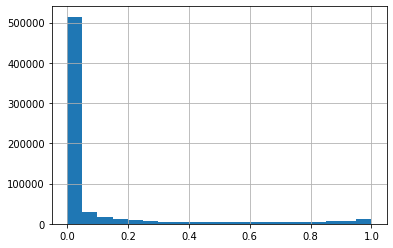

In [28]:
target_df["pred"] = oof_pred
display(target_df["pred"].hist(bins=20))

In [29]:
train = pd.read_csv(CFG["TRAIN_LABEL_CSV"])
if CFG["DEBUG"]:
    train = train.sample(5000).reset_index(drop=True)

train = pd.merge(train, target_df[["contact_id", "pred"]], on="contact_id", how="left")
train = train.fillna(0)
print(len(train))

def func(x_list):
    score = matthews_corrcoef(train['contact'], train["pred"]>x_list[0])
    return -score
x0 = [0.5]
result = minimize(func, x0,  method="nelder-mead")
opt_threshold = result.x[0]
score = round(matthews_corrcoef(train['contact'], train["pred"]>opt_threshold), 5)
threshold = round(opt_threshold, 5)
print(f"score:{score}, threshold:{threshold}")

4721618
score:0.72784, threshold:0.34053


## post proc

In [30]:
train = pd.read_csv(CFG["TRAIN_LABEL_CSV"])
# train = train[train["game_play"].isin(train_game_play)]
print(len(train))

# scoring post process
print(f"score:{score}, threshold:{threshold}")
output_threshold =threshold
best_score = score
best_threshold = threshold
best_window = 1

for window_size in [3, 5, 7, 9, 11, 13]:
    print(f"window size = {window_size}", end=", ")
    proc_sub = post_proc_roll(train, target_df, window_size)
    def func(x_list):
        score = matthews_corrcoef(proc_sub['contact'], proc_sub["proc_pred"]>x_list[0])
        return -score
    x0 = [0.5]
    result = minimize(func, x0,  method="nelder-mead")
    opt_threshold = result.x[0]
    score = round(matthews_corrcoef(proc_sub['contact'], proc_sub["proc_pred"]>opt_threshold), 5)
    threshold = round(opt_threshold, 5)
    print(f"score:{score}, threshold:{threshold}")
    if score > best_score:
        best_score = score
        best_threshold = threshold
        best_window = window_size
print(f"BEST SCORE => window size:{best_window}, score:{best_score}, threshold:{best_threshold} ")

4721618
score:0.72784, threshold:0.34053
window size = 3, score:0.73718, threshold:0.34727
window size = 5, score:0.7395, threshold:0.32354
window size = 7, score:0.73943, threshold:0.32588
window size = 9, score:0.73687, threshold:0.3373
window size = 11, score:0.73427, threshold:0.3375
window size = 13, score:0.73026, threshold:0.329
BEST SCORE => window size:5, score:0.7395, threshold:0.32354 


In [31]:
print(len(FEATURE_COLS))
print(FEATURE_COLS)
del train

156
['nfl_player_id_1', 'nfl_player_id_2', 'step', 'x_position_1', 'y_position_1', 'speed_1', 'distance_1', 'direction_1', 'orientation_1', 'acceleration_1', 'sa_1', 'team_1', 'jersey_number_1', 'is_lineman_1', 'x_position_shift-6_1', 'x_position_shift-5_1', 'x_position_shift-4_1', 'x_position_shift-3_1', 'x_position_shift-2_1', 'x_position_shift-1_1', 'x_position_shift0_1', 'x_position_shift1_1', 'x_position_shift2_1', 'x_position_shift3_1', 'x_position_shift4_1', 'x_position_shift5_1', 'y_position_shift-6_1', 'y_position_shift-5_1', 'y_position_shift-4_1', 'y_position_shift-3_1', 'y_position_shift-2_1', 'y_position_shift-1_1', 'y_position_shift0_1', 'y_position_shift1_1', 'y_position_shift2_1', 'y_position_shift3_1', 'y_position_shift4_1', 'y_position_shift5_1', 'x_position_2', 'y_position_2', 'speed_2', 'distance_2', 'direction_2', 'orientation_2', 'acceleration_2', 'sa_2', 'team_2', 'jersey_number_2', 'is_lineman_2', 'x_position_shift-6_2', 'x_position_shift-5_2', 'x_position_shift

In [32]:
CFG["features"] = FEATURE_COLS
CFG["PRED_THR"] = output_threshold
CFG["PROC_PRED_THR"] = best_threshold
CFG["proc_window_size"] = best_window

import yaml

cofig_yaml = os.path.join(CFG["EXP_DIR"], "Config.yaml")
with open(cofig_yaml, "w") as f:
    yaml.dump(CFG, f)